In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

# Load the datasets
players = pd.read_csv('processed_data/players.csv')
games = pd.read_csv('processed_data/games.csv')
test = pd.read_csv('processed_data/test.csv')
# games = pd.read_csv('processed_data/knn_games_df.csv')
# test = pd.read_csv('processed_data/knn_test_df.csv')


In [22]:
games['feature'] = [[] for _ in range(len(games))]
test['feature'] = [[] for _ in range(len(test))]
games['is_home_winner'] = games['home_team_goal'] > games['away_team_goal']
player_columns = [f"home_player_{i}" for i in range(1, 12)] + [f"away_player_{i}" for i in range(1, 12)]    
positions = ['GK', 'DEF', 'MID', 'FWD']
feature_name =[]

# Creating Features

In [23]:
# Adding 66 features
player_stat = ['overall_rating', 'potential', 'crossing']
def get_player_stats(player_id, year):
    # Get the most recent player stats for a given player and year
    player_data = players[(players['player_id'] == player_id) & (players['year'] <= year)].sort_values('year', ascending=False).iloc[0]
    return player_data[player_stat].values

def add_player_stats_features(row, features, is_test=False):
    year = 2015 if is_test else row['year']
    
    for player_col in player_columns:
        if pd.notna(row[player_col]):
            player_stats = get_player_stats(row[player_col], year)
            features.extend(player_stats)
        else:
            features.extend([0, 0, 0])  # Default values for missing players

feature_name.extend([f"home_player_{i}_{stat}" for i in range(1, 12) for stat in player_stat] + [f"away_player_{i}_{stat}" for i in range(1, 12) for stat in player_stat])

In [24]:
# Adding 6 features
def get_team_historical_goal_mean(team_id, year):
    # Get the historical average goals scored by a team at home and away games
    team_games = games[(games['home_team_id'] == team_id) | (games['away_team_id'] == team_id) & (games['year'] <= year)]
    home_goals = team_games[team_games['home_team_id'] == team_id]['home_team_goal'].mean()
    away_goals = team_games[team_games['away_team_id'] == team_id]['away_team_goal'].mean()
    
    total_goals = team_games[(team_games['home_team_id'] == team_id)]['home_team_goal'].sum() + \
                  team_games[(team_games['away_team_id'] == team_id)]['away_team_goal'].sum()
    total_games = team_games[(team_games['home_team_id'] == team_id)].shape[0] + \
                  team_games[(team_games['away_team_id'] == team_id)].shape[0]
                  
    total_mean = total_goals / total_games if total_games > 0 else 0
    
    return np.array([home_goals, away_goals, total_mean])

def add_team_historical_goal_features(row, features, is_test=False):
    year = 2015 if is_test else row['year']
    
    home_team_stats = get_team_historical_goal_mean(row['home_team_id'], year)
    away_team_stats = get_team_historical_goal_mean(row['away_team_id'], year)
    
    features.extend(home_team_stats)
    features.extend(away_team_stats)
    
feature_name.extend(['home_team_home_goal_mean', 'home_team_away_goal_mean', 'home_team_total_goal_mean','away_team_home_goal_mean', 'away_team_away_goal_mean', 'away_team_total_goal_mean'])

In [25]:
# Adding 8 features
positions = ['GK', 'DEF', 'MID', 'FWD']

def get_position_ratings(row, team, year):
    ratings = {pos: [] for pos in positions}
    for i in range(1, 12):
        player_id = row[f'{team}_player_{i}']
        if pd.notna(player_id):
            # Getting the latest player data
            player_data = players[(players['player_id'] == player_id) & (players['year'] <= year)].sort_values('year', ascending=False).iloc[0]
            position = positions[min(int(row[f'{team}_player_Y{i}']) // 3, 3)]  # Map Y-coordinate to position
            ratings[position].append(player_data['overall_rating'])
    return {pos: np.mean(r) if r else 0 for pos, r in ratings.items()}


def add_position_ratings_features(row, features, is_test=False):
    year = 2015 if is_test else row['year']

    home_position_stats = get_position_ratings(row, 'home', year)
    away_position_stats = get_position_ratings(row, 'away', year)
    
    for pos in positions:
        features.append(home_position_stats[pos])
        features.append(away_position_stats[pos])
        
feature_name.extend(["home_GK_rating", "away_GK_rating", "home_DEF_rating", "away_DEF_rating", "home_MID_rating", "away_MID_rating", "home_FWD_rating", "away_FWD_rating"])

In [26]:
# Adding 6 features
def get_team_historical_winning_rate(team_id, year, index):
    
    # Get the historical games
    home_games = games[(games['home_team_id'] == team_id) & (games['year'] <= year)]
    away_games = games[(games['away_team_id'] == team_id) & (games['year'] <= year)]
    
    home_games = home_games.drop(index) if index in home_games.index else home_games
    away_games = away_games.drop(index) if index in away_games.index else away_games
    
    # Get all games if no history
    if len(home_games) == 0 or len(away_games) == 0:
        home_games = games[(games['home_team_id'] == team_id)]
        away_games = games[(games['away_team_id'] == team_id)]
        
    # Use away games for home games if no home games and vice versa
    if len(home_games) == 0:
        home_games = games[(games['away_team_id'] == team_id)]
        
    if len(away_games) == 0:
        away_games = games[(games['home_team_id'] == team_id)]
    
    # Default values if no games
    if len(home_games) == 0 or len(away_games) == 0:
        return np.array([0.5, 0.5, 0.5])    
    
    home_games_winning = home_games[home_games['is_home_winner'] == True]
    away_games_winning = away_games[away_games['is_home_winner'] == False]
        
    home_games_winning_rate = len(home_games_winning) / len(home_games)
    away_games_winning_rate = len(away_games_winning) / len(away_games)
    
    total_winning_rate = (len(home_games_winning) + len(away_games_winning)) / (len(home_games) + len(away_games))
    
    return np.array([home_games_winning_rate, away_games_winning_rate, total_winning_rate])

def add_team_historical_winning_rate_features(row, features, is_test=False):
    year = 2015 if is_test else row['year']
    
    home_team_winning_rate = get_team_historical_winning_rate(row['home_team_id'], year, row.name)    
    away_team_winning_rate = get_team_historical_winning_rate(row['away_team_id'], year, row.name)
    
    features.extend(home_team_winning_rate)
    features.extend(away_team_winning_rate)
    
feature_name.extend(['home_team_home_winning_rate', 'home_team_away_winning_rate', 'home_team_total_winning_rate', 'away_team_home_winning_rate', 'away_team_away_winning_rate', 'away_team_total_winning_rate'])

In [27]:
def get_head_to_head_winning_rate(team1_id, team2_id, year, index):
    h2h_games = games[
        (((games['home_team_id'] == team1_id) & (games['away_team_id'] == team2_id)) |
         ((games['home_team_id'] == team2_id) & (games['away_team_id'] == team1_id))) &
        (games['year'] <= year ) 
        ]
    
    if h2h_games.empty:
        h2h_games = games[
        (((games['home_team_id'] == team1_id) & (games['away_team_id'] == team2_id)) |
         ((games['home_team_id'] == team2_id) & (games['away_team_id'] == team1_id)))
        ]
    
    h2h_games = h2h_games.drop(index) if index in h2h_games.index else h2h_games
    
    team1_wins = ((h2h_games['home_team_id'] == team1_id) & (h2h_games['is_home_winner'] == True)).sum() + \
                 ((h2h_games['away_team_id'] == team1_id) & (h2h_games['is_home_winner'] == False)).sum()
    
    total_games = len(h2h_games)
    
    return [team1_wins / total_games if total_games > 0 else 0.5]

def add_head_to_head_winning_rate_features(row, features, is_test=False):
    year = 2015 if is_test else row['year']
    
    h2h_winning_rate = get_head_to_head_winning_rate(row['home_team_id'], row['away_team_id'], year, row.name)
    features.extend(h2h_winning_rate)
    
feature_name.extend(['home_team_head_to_head_winning_rate'])

In [ ]:
# Adding 4 new features
def get_work_rate_averages(row, team, year):
    attacking_rates = []
    defensive_rates = []
    for i in range(1, 12):
        player_id = row[f'{team}_player_{i}']
        y_coord = row[f'{team}_player_Y{i}']
        if pd.notna(player_id) and pd.notna(y_coord):
            # Getting the latest player data
            player_data = players[(players['player_id'] == player_id) & (players['year'] <= year)].sort_values('year', ascending=False).iloc[0]
            if 6 <= y_coord <= 10:
                attacking_rates.append(player_data['attacking_work_rate'])
            else:
                defensive_rates.append(player_data['defensive_work_rate'])
    
    avg_attacking = np.mean(attacking_rates) if attacking_rates else 1
    avg_defensive = np.mean(defensive_rates) if defensive_rates else 1
    return avg_attacking, avg_defensive

def add_work_rate_features(row, features, is_test=False):
    year = 2015 if is_test else row['year']

    home_attacking, home_defensive = get_work_rate_averages(row, 'home', year)
    away_attacking, away_defensive = get_work_rate_averages(row, 'away', year)
    
    features.extend([home_attacking, home_defensive, away_attacking, away_defensive])

feature_name.extend(["home_attacking_work_rate", "home_defensive_work_rate", "away_attacking_work_rate", "away_defensive_work_rate"])

In [40]:
def get_team_stats(row, team, year):
    team_stats = {stat: [] for stat in player_stat}
    
    for i in range(1, 12):
        player_id = row[f'{team}_player_{i}']
        if pd.notna(player_id):
            player_data = players[(players['player_id'] == player_id) & (players['year'] <= year)].sort_values('year', ascending=False).iloc[0]
            for stat in player_stat:
                team_stats[stat].append(player_data[stat])
    
    stats_summary = []
    for stat in player_stat:
        if team_stats[stat]:
            stats_summary.extend([np.mean(team_stats[stat]), np.std(team_stats[stat])])
        else:
            stats_summary.extend([np.nan, np.nan])
    
    return stats_summary

def add_team_stats_features(row, features, is_test=False):
    year = 2015 if is_test else row['year']
    
    home_stats = get_team_stats(row, 'home', year)
    away_stats = get_team_stats(row, 'away', year)
    
    features.extend(home_stats)
    features.extend(away_stats)

# Update feature names
feature_name.extend([f"{team}_{stat}_{metric}" for team in ['home', 'away'] for stat in player_stat for metric in ['mean', 'std']])

In [8]:
def create_features(row, features, is_test=False):
    add_player_stats_features(row, features, is_test)
    add_team_historical_goal_features(row, features, is_test)
    add_position_ratings_features(row, features, is_test)
    add_team_historical_winning_rate_features(row, features, is_test)
    add_head_to_head_winning_rate_features(row, features, is_test)
    add_work_rate_features(row, features, is_test)
    add_team_stats_features(row, features, is_test)

In [41]:
# To be used to add only one feature
games['tmp_feature'] = [[] for _ in range(len(games))]
test['tmp_feature'] = [[] for _ in range(len(test))]
adding_feature = add_team_stats_features

games.apply(lambda row: adding_feature(row, row['tmp_feature']), axis=1)
test.apply(lambda row: adding_feature(row, row['tmp_feature'], is_test=True), axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
995    None
996    None
997    None
998    None
999    None
Length: 1000, dtype: object

In [49]:
games['tmp_feature']

0        [65.72727272727273, 1.7627926754241197, 68.090...
1        [67.0, 2.486326242032244, 69.63636363636364, 3...
2        [62.90909090909091, 2.7453943400984544, 67.272...
3        [68.45454545454545, 2.6410616447879907, 73.636...
4        [63.63636363636363, 3.7482778414706006, 68.545...
                               ...                        
16578    [71.36363636363636, 2.603240193322973, 76.0, 4...
16579    [62.09090909090909, 3.752684989190962, 63.8181...
16580    [61.27272727272727, 4.59428318854301, 62.90909...
16581    [66.72727272727273, 6.482015807263958, 69.3636...
16582    [65.18181818181819, 3.9038019188334343, 70.727...
Name: tmp_feature, Length: 16583, dtype: object

In [50]:
# Combine 'tmp_feature' and 'feature' columns
games['feature'] = games.apply(lambda row: row['feature'] + row['tmp_feature'], axis=1)
test['feature'] = test.apply(lambda row: row['feature'] + row['tmp_feature'], axis=1)

In [11]:
games.apply(lambda row: create_features(row, row['feature']), axis=1)
test.apply(lambda row: create_features(row, row['feature'], is_test=True), axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
995    None
996    None
997    None
998    None
999    None
Length: 1000, dtype: object

In [69]:
games['feature'] =games['feature'].apply(lambda row: row[66:])
test['feature'] = test['feature'].apply(lambda row: row[66:])

### Save to csv and load

In [12]:
# import os

# games.to_csv(os.path.join("processed_data", "games_feature.csv"), index=False)
# test.to_csv(os.path.join("processed_data", "test_feature.csv"), index=False)

In [4]:
import pandas as pd

def string_to_numpy(string_repr):
    cleaned_string = string_repr.replace('np.float64(', '').replace(')', '')
    numpy_list = np.fromstring(cleaned_string[1:-1], sep=',')
    return numpy_list


games = pd.read_csv('processed_data/games_feature.csv')
games['feature'] = games['feature'].apply(string_to_numpy)

test = pd.read_csv('processed_data/test_feature.csv')
test['feature'] = test['feature'].apply(string_to_numpy)



In [5]:
X = np.vstack(games['feature'].values)
X_to_predict = np.vstack(test['feature'].values)

# Creating a model for winner

In [75]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler

games['is_home_winner'] = games['home_team_goal'] > games['away_team_goal']
y = games['is_home_winner'].values

# Split the training data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the GradientBoostingRegressor
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

winner_boosting_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values by filling with the mean
    # ('imputer', KNNImputer(n_neighbors=1)), # Marginally better than SimpleImputer (0.0001)
    ('scaler', StandardScaler()),
    ('regressor', ensemble.GradientBoostingRegressor(**params))
])

winner_boosting_pipeline.fit(X_train, y_train)

# Evaluate the model
val_predictions = winner_boosting_pipeline.predict(X_val)
rmse = root_mean_squared_error(y_val, val_predictions)
print(f"Validation rmse: {rmse:.4f}")
# Validation rmse: 0.4567
# Validation rmse: 0.4566


KeyboardInterrupt: 

In [14]:
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Assuming games dataset is already defined and preprocessed
games['is_home_winner'] = games['home_team_goal'] > games['away_team_goal']
y = games['is_home_winner'].values

# Split the training data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameter search space
param_distributions = {
    'regressor__n_estimators': [100, 200, 300, 500],       # Number of boosting rounds
    'regressor__max_depth': [3, 4, 5, 6, 7],              # Maximum depth of trees
    'regressor__learning_rate': [0.001, 0.01, 0.05, 0.1], # Learning rate
    'regressor__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],    # Fraction of samples used per tree
    'regressor__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], # Fraction of features used per tree
    'regressor__reg_alpha': [0, 0.1, 0.5, 1.0],           # L1 regularization (alpha)
    'regressor__reg_lambda': [0.1, 1.0, 5.0, 10.0]        # L2 regularization (lambda)
}

# Build the pipeline with XGBoost Regressor
winner_boosting_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values by filling with the most frequent value
    ('scaler', StandardScaler()),  # Standardize features
    ('regressor', xgb.XGBRegressor(objective="reg:squarederror", random_state=42))  # XGBoost Regressor
])

# Perform randomized search with cross-validation
winner_boosting_random_search = RandomizedSearchCV(
    winner_boosting_pipeline, 
    param_distributions=param_distributions, 
    n_iter=30,  # Number of parameter settings sampled
    scoring='neg_mean_squared_error',  # Scoring method (negative MSE)
    cv=3,  # 3-fold cross-validation
    verbose=1,  # Verbosity level
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Run the search and fit the best model
winner_boosting_random_search.fit(X_train, y_train)

# Get the best parameters
print(f"Best parameters: {winner_boosting_random_search.best_params_}")

# Evaluate the model using the best found parameters
val_predictions = winner_boosting_random_search.predict(X_val)

# Root Mean Squared Error (RMSE) evaluation
rmse = root_mean_squared_error(y_val, val_predictions)
print(f"Validation RMSE: {rmse:.4f}")
#Validation RMSE: 0.3679


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters: {'regressor__subsample': 1.0, 'regressor__reg_lambda': 5.0, 'regressor__reg_alpha': 0.5, 'regressor__n_estimators': 500, 'regressor__max_depth': 6, 'regressor__learning_rate': 0.05, 'regressor__colsample_bytree': 0.9}
Validation RMSE: 0.3679


In [11]:
import matplotlib.pyplot as plt

# Access the trained regressor from the pipeline
regressor = winner_boosting_pipeline.named_steps['regressor']

# Get the feature importances
feature_importances = regressor.feature_importances_
len(feature_importances)
# Create a plot to visualize feature importance
def plot_feature_importances(importances, feature_name):
    indices = np.argsort(importances)
    plt.figure(figsize=(10, 20))
    plt.barh(range(len(importances)), importances[indices], align='center')
    plt.yticks(range(len(importances)), [feature_name[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance in Gradient Boosting Regressor')
    plt.show()


plot_feature_importances(feature_importances, feature_name[66:])

NameError: name 'feature_name' is not defined

# Winning score predict

In [80]:
# Set y value
games['goal_diff'] = (games['home_team_goal'] - games['away_team_goal']).abs()
y = games['goal_diff'].values

# Split the training data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the GradientBoostingRegressor
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

win_by_boosting_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Handle missing values by filling with the mean
    # ('imputer', KNNImputer(n_neighbors=1)), # Did not improve the model
    ('scaler', StandardScaler()),
    ('regressor', ensemble.GradientBoostingRegressor(**params))
])

win_by_boosting_pipeline.fit(X_train, y_train)

# Evaluate the model using Mean Squared Error
val_predictions = win_by_boosting_pipeline.predict(X_val)
rmse = root_mean_squared_error(y_val, val_predictions)
print(f"Validation rmse: {rmse:.4f}")
# Validation rmse: 1.1635
# Validation rmse: 1.1627

Validation rmse: 1.1627


In [13]:
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

games['goal_diff'] = (games['home_team_goal'] - games['away_team_goal']).abs()
y = games['goal_diff'].values

# Split the training data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameter search space
param_distributions = {
    'regressor__n_estimators': [100, 200, 300, 500],       # Number of boosting rounds
    'regressor__max_depth': [3, 4, 5, 6, 7],              # Maximum depth of trees
    'regressor__learning_rate': [0.001, 0.01, 0.05, 0.1], # Learning rate
    'regressor__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],    # Fraction of samples used per tree
    'regressor__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], # Fraction of features used per tree
    'regressor__reg_alpha': [0, 0.1, 0.5, 1.0],           # L1 regularization (alpha)
    'regressor__reg_lambda': [0.1, 1.0, 5.0, 10.0]        # L2 regularization (lambda)
}

# Build the pipeline with XGBoost Regressor
win_by_boosting_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing values by filling with the most frequent value
    ('scaler', StandardScaler()),  # Standardize features
    ('regressor', xgb.XGBRegressor(objective="reg:squarederror", random_state=42))  # XGBoost Regressor
])

# Perform randomized search with cross-validation
win_by_boosting_random_search = RandomizedSearchCV(
    win_by_boosting_pipeline, 
    param_distributions=param_distributions, 
    n_iter=30,  # Number of parameter settings sampled
    scoring='neg_mean_squared_error',  # Scoring method (negative MSE)
    cv=3,  # 3-fold cross-validation
    verbose=1,  # Verbosity level
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Run the search and fit the best model
win_by_boosting_random_search.fit(X_train, y_train)

# Get the best parameters
print(f"Best parameters: {win_by_boosting_random_search.best_params_}")

# Evaluate the model using the best found parameters
val_predictions = win_by_boosting_random_search.predict(X_val)

# Root Mean Squared Error (RMSE) evaluation
rmse = root_mean_squared_error(y_val, val_predictions)
print(f"Validation RMSE: {rmse:.4f}")
#Validation RMSE: 1.1610

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters: {'regressor__subsample': 0.6, 'regressor__reg_lambda': 10.0, 'regressor__reg_alpha': 0.5, 'regressor__n_estimators': 500, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.01, 'regressor__colsample_bytree': 1.0}
Validation RMSE: 1.1610


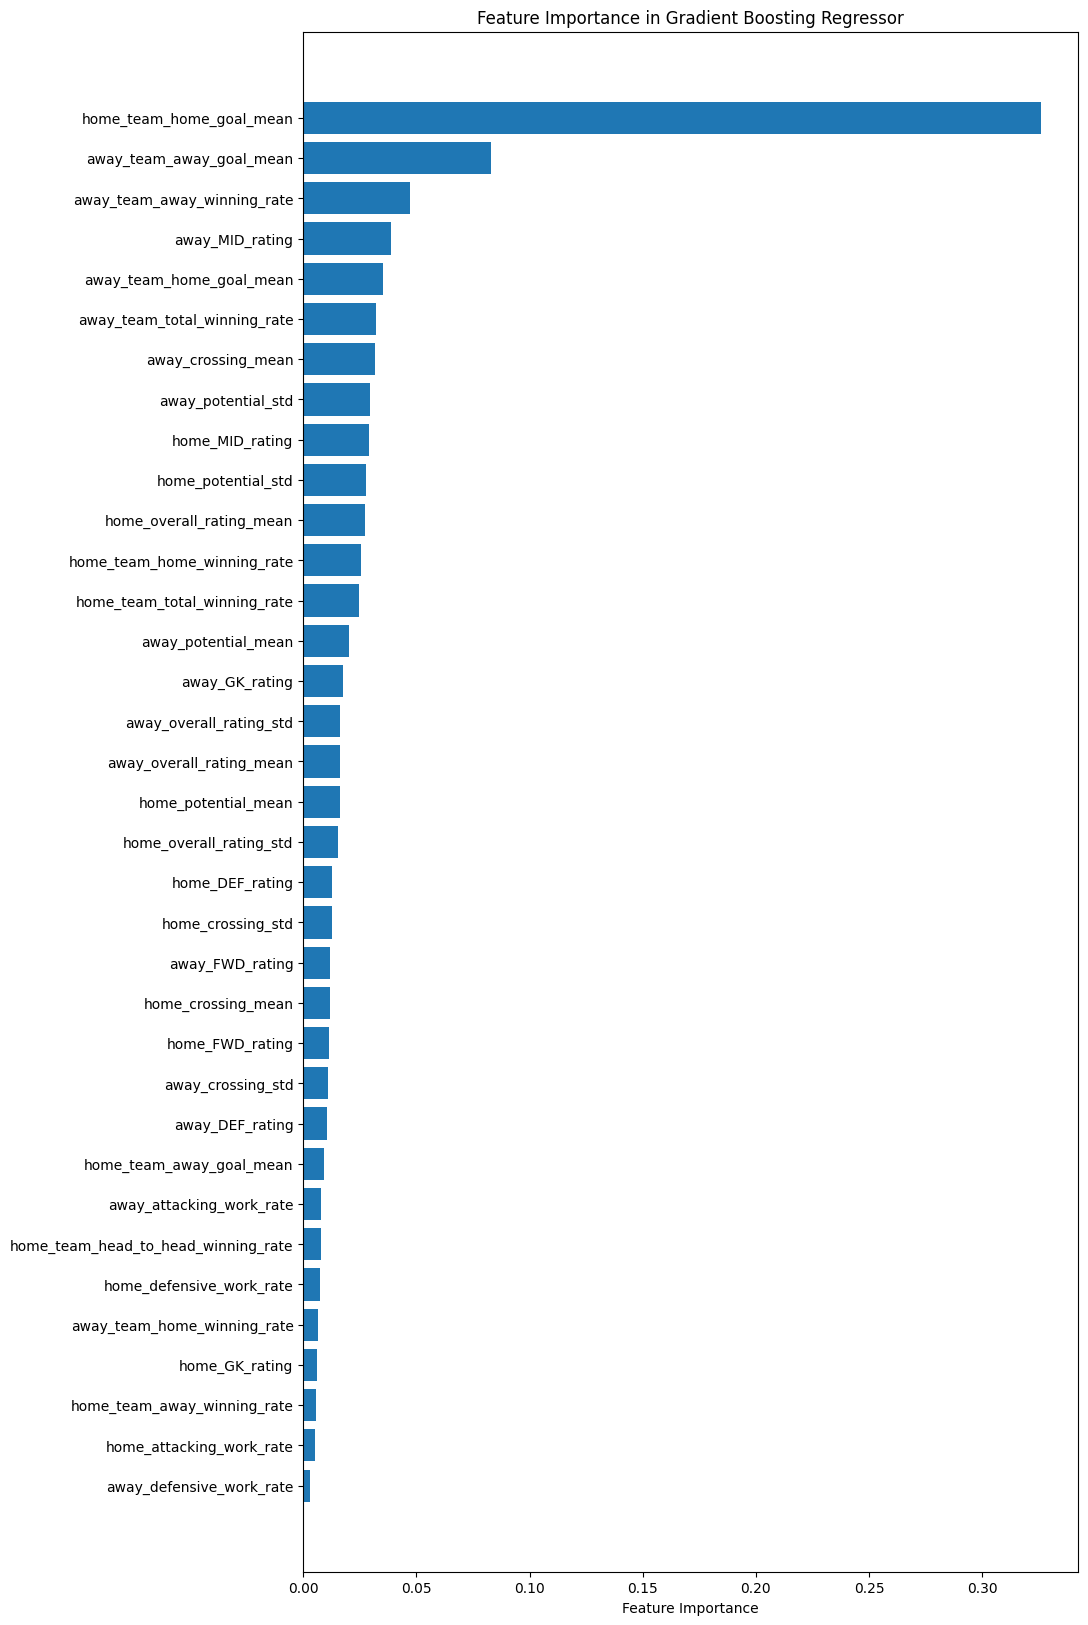

In [77]:
import matplotlib.pyplot as plt

# Access the trained regressor from the pipeline
regressor = win_by_boosting_pipeline.named_steps['regressor']

# Get the feature importances
feature_importances = regressor.feature_importances_

# Create a plot to visualize feature importance
def plot_feature_importances(importances, feature_name):
    indices = np.argsort(importances)
    plt.figure(figsize=(10, 20))
    plt.barh(range(len(importances)), importances[indices], align='center')
    plt.yticks(range(len(importances)), [feature_name[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance in Gradient Boosting Regressor')
    plt.show()


plot_feature_importances(feature_importances, feature_name[66:])

# Predict Test data

In [15]:
# Train with all data
games['is_home_winner'] = games['home_team_goal'] > games['away_team_goal']
y = games['is_home_winner'].values
winner_boosting_random_search.fit(X, y)

games['goal_diff'] = (games['home_team_goal'] - games['away_team_goal']).abs()
y = games['goal_diff'].values
win_by_boosting_random_search.fit(X, y)

winner = winner_boosting_random_search.predict(X_to_predict)
winby = win_by_boosting_random_search.predict(X_to_predict)

predictions_df = pd.DataFrame({
    'winner': winner,
    'winby': winby
})

predictions_df.to_csv('processed_data/predictions_with_feature_engineer_xgboost.csv', index=False)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits


## Predict with KNN test df

In [18]:
knn_test = pd.read_csv('processed_data/knn_test_df.csv')
knn_test['feature'] = [[] for _ in range(len(test))]
knn_test.apply(lambda row: create_features(row, row['feature'], is_test=True), axis=1)
X_knn_to_predict = np.vstack(knn_test['feature'].values)

winner = winner_boosting_pipeline.predict(X_knn_to_predict)
winby = win_by_boosting_pipeline.predict(X_knn_to_predict)

predictions_df = pd.DataFrame({
    'winner': winner,
    'winby': winby
})

predictions_df.to_csv('processed_data/predictions_with_feature_engineer_knn_test.csv', index=False)

In [17]:
winby_df = pd.read_csv('data/example.csv')
winby_df['winby'] = winby
winby_df.to_csv('processed_data/winby.csv', index=False)

winner_df = pd.read_csv('data/example.csv')
winner_df['winner'] = winner
winner_df.to_csv('processed_data/winner.csv', index=False)

# winby is 8.8
# winner is 22.1